In [ ]:
#Importing all the necessary libraries required for this code
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.layers.recurrent import GRU
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import SGD
from keras.utils.vis_utils import plot_model
import h5py
from keras.models import load_model
import os

In [ ]:
#Code section to upload dataset to google drive for the execution
from google.colab import files
#uploaded = files.upload()#uncomment to upload a local file

In [ ]:
dataset = pd.read_excel("telstradataset.xlsx")#Read the excel dataset file 
dataset.head(10)#Display the top 10 rows

,Date,Open,High,Low,Close,Adj Close,Volume,AverageSentiment_tweets,Two_day_sentiment_tweets,Three_day_sentiment_tweets,AverageSentimentNews,Two_day_sentiment_news
0,2018-01-02,3.64,3.675,3.630,3.66,3.425345,8990912,0.127597,0.472365,0.588664,0.000000,0.000000
1,2018-01-03,3.67,3.685,3.645,3.66,3.425345,12418563,0.021953,0.247159,0.428719,0.000000,0.000000
2,2018-01-04,3.68,3.690,3.670,3.68,3.444062,12158560,0.028536,0.137848,0.348640,0.000000,0.000000
3,2018-01-05,3.70,3.730,3.690,3.73,3.490857,18064317,0.337952,0.237900,0.371770,0.000000,0.000000
4,2018-01-08,3.74,3.760,3.730,3.75,3.509574,18490173,-0.401830,-0.090280,-0.050480,0.096608,0.096608
5,2018-01-09,3.77,3.785,3.750,3.75,3.509574,25741244,0.058605,-0.033230,0.063949,0.051350,0.073979
6,2018-01-10,3.78,3.780,3.700,3.71,3.472139,29423537,0.041660,0.004215,0.018377,0.000000,0.000000
7,2018-01-11,3.70,3.735,3.680,3.71,3.472139,15919079,0.260088,0.132151,0.114138,-0.200950,-0.200950
8,2018-01-12,3.73,3.750,3.700,3.74,3.500216,26797583,-0.475140,-0.171500,-0.114210,0.110332,-0.045309
9,2018-01-15,3.75,3.760,3.700,3.71,3.472139,14124236,0.023075,-0.031640,-0.032650,0.025000,0.183511


In [ ]:
training_set = dataset
training_set.describe()#Display the statistics of the dataset

,Open,High,Low,Close,Adj Close,Volume,AverageSentiment_tweets,Two_day_sentiment_tweets,Three_day_sentiment_tweets,AverageSentimentNews,Two_day_sentiment_news
count,761.000000,761.000000,761.000000,761.000000,761.000000,7.610000e+02,761.000000,761.000000,761.000000,761.000000,761.000000
mean,3.270539,3.301380,3.240736,3.272017,3.159929,2.907550e+07,0.105556,0.094729,0.097954,0.044543,0.037431
std,0.337309,0.338043,0.335868,0.337741,0.330581,1.488642e+07,0.248223,0.144423,0.111183,0.142651,0.111218
min,2.620000,2.640000,2.600000,2.620000,2.476862,3.164766e+06,-0.790670,-0.342730,-0.263230,-0.675950,-0.675950
25%,3.030000,3.070000,3.010000,3.040000,2.930638,1.956644e+07,-0.042410,0.002523,0.030430,0.000000,-0.009276
50%,3.220000,3.250000,3.180000,3.210000,3.099957,2.592040e+07,0.115999,0.087713,0.091217,0.000000,0.013158
75%,3.560000,3.580000,3.520000,3.560000,3.433497,3.449690e+07,0.253755,0.181862,0.171017,0.102800,0.090959
max,3.980000,4.010000,3.950000,3.990000,3.850433,1.273549e+08,0.843987,0.631044,0.588664,0.776325,0.781137


In [ ]:
training_set.isnull().sum()#Check if any element has NULL value
#In the dataset as there is no NULL value and so no pro-processing is necessary

Date                          0
Open                          0
High                          0
Low                           0
Close                         0
Adj Close                     0
Volume                        0
AverageSentiment_tweets       0
Two_day_sentiment_tweets      0
Three_day_sentiment_tweets    0
AverageSentimentNews          0
Two_day_sentiment_news        0
dtype: int64

In [ ]:
training_set = dataset[dataset['Date']<'2020-11-01'].copy()#Separate the dataset based on date
testing_set = dataset[dataset['Date']>='2020-11-01'].copy()#Testing dataset
testing_set_copy12 = testing_set
training_set_copy12 = training_set
print(training_set.shape)
print(testing_set.shape)

          Date  Open  ...  AverageSentimentNews  Two_day_sentiment_news
730 2020-11-17  3.16  ...              0.088917                0.051948
731 2020-11-18  3.13  ...              0.052675                0.052312
732 2020-11-19  3.09  ...              0.055962                0.054137
733 2020-11-20  3.11  ...              0.000000                0.027069
734 2020-11-23  3.10  ...              0.021092                0.021092
735 2020-11-24  3.09  ...              0.166538                0.093815
736 2020-11-25  3.13  ...              0.056920                0.075367
737 2020-11-26  3.11  ...              0.095660                0.085514
738 2020-11-27  3.11  ...              0.107546                0.096530
739 2020-11-30  3.12  ...              0.000000                0.000000
740 2020-12-01  3.09  ...              0.000000                0.000000
741 2020-12-02  3.09  ...             -0.005503               -0.005503
742 2020-12-03  3.06  ...              0.208537                0

Both the training and testing dataset consists of 12 columns, the rows varies. But all the columns will not be used for analysis and so the columns to be used must be selected.

In [ ]:
training_set.columns### The names of all the columns present in the dataset

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'AverageSentiment_tweets', 'Two_day_sentiment_tweets',
       'Three_day_sentiment_tweets', 'AverageSentimentNews',
       'Two_day_sentiment_news'],
      dtype='object')

In [ ]:
#Need to select the columns on which analysis is to be made
#training_set = training_set[['Open','High','Low','Close','Volume','AverageSentiment_tweets','AverageSentimentNews']]
selected_columns = ['Open','High','Low','Close','Two_day_sentiment_tweets','AverageSentimentNews']#Mention the columns to be selected for the analysis purpose
training_set = training_set[selected_columns]
print(training_set.columns)
print(training_set.tail(10))

Index(['Open', 'High', 'Low', 'Close', 'Two_day_sentiment_tweets',
       'AverageSentimentNews'],
      dtype='object')
     Open   High    Low  Close  Two_day_sentiment_tweets  AverageSentimentNews
720  2.73  2.775  2.730   2.76                  0.079640              0.574200
721  2.76  2.765  2.710   2.73                  0.059120              0.420417
722  2.74  2.780  2.730   2.78                  0.059120              0.000000
723  2.79  2.810  2.770   2.80                  0.059120              0.000000
724  2.81  2.870  2.800   2.86                  0.193561              0.033333
725  2.90  2.950  2.885   2.90                  0.030826             -0.074197
726  2.92  3.005  2.915   2.99                  0.054215              0.000000
727  3.18  3.190  3.070   3.08                  0.124972              0.129892
728  3.08  3.140  3.080   3.13                  0.001080              0.248465
729  3.15  3.165  3.140   3.16                  0.279643              0.029960


In [ ]:
#Code section to scale the training set 
sc = MinMaxScaler()#setting the range between 0 and 1
training_set_scaled = sc.fit_transform(training_set)#Transform the training set into scaled features
print("Scalar Minimum value:" + str(sc.min_))
print("Scalar scale value:" + str(sc.scale_))

Scalar Minimum value:[-1.92647059 -1.9270073  -1.92592593 -1.91240876  0.35196052  0.46544215]
Scalar scale value:[0.73529412 0.72992701 0.74074074 0.72992701 1.02693233 0.68857482]


In [ ]:
# Creating a data structure with 90 timesteps and 1 output
#because rnn must have historical data and so training set will have 90 previous days data in different columns
#and the actual stock value in the y_train value
X_train = []
y_train = []

###Setting the future days for which it needs to be predicted
future_days = 1
for i in range(90,training_set_scaled.shape[0]-future_days+1):
  if training_set_scaled.shape[1]==1:
    X_train.append(training_set_scaled[i-90:i, 0])#if only a single column is used then only append the first column
  else:
    X_train.append(training_set_scaled[i-90:i])#if multiple columns are used then append all columns
  y_train.append(training_set_scaled[i:i+future_days, 0])

X_train, y_train = np.array(X_train), np.array(y_train)##Convert it into an array
print("The training set is of shape:" + str(X_train.shape))
print("The testing set if of shape:" + str(y_train.shape))

The training set is of shape:(640, 90, 6)
The testing set if of shape:(640, 1)


In [ ]:
scale1 = MinMaxScaler()
scale1.min_,scale1.scale_ = sc.min_[0],sc.scale_[0]##Taking the scalar values from the previous scalar
##Because the previous scalar had n dimensions but now the predicted is only 1 column

print("Checking if the RNN data was setup properly")
##The predicted price and the test data is inverse transformed
#print(scale1.inverse_transform(X_train[:,:,0]))
#print(scale1.inverse_transform(y_train))

Checking if the RNN data was setup properly


In [ ]:
# The xtrain dataset needs to be reshaped if it consist of only one column data
if training_set_scaled.shape[1]==1:
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))#uncomment if only one column is used

In [ ]:
train_model = 'GRU'
if train_model=='LSTM':
  if os.path.isfile("LSTM_trained_model.h5"):
    regressior = load_model('LSTM_trained_model.h5')
    print(regressior.summary())
  else:  
    #Building the Recurrent Neural Network LSTM
    regressior = Sequential() #initializing the RNN by saying that the model will be sequential
    # Adding the first LSTM layer and some Dropout regularisation
    regressior.add(LSTM(units = 320, activation = 'tanh', return_sequences = True, input_shape = (X_train.shape[1], training_set_scaled.shape[1])))
    regressior.add(Dropout(0.2))
    # Adding a second LSTM layer and some Dropout regularisation
    #regressior.add(LSTM(units = 60, activation = 'tanh', return_sequences = True))
    ##regressior.add(Dropout(0.2))
    # Adding a third LSTM layer and some Dropout regularisation
    #regressior.add(LSTM(units = 160, activation = 'tanh', return_sequences = True))
    #regressior.add(Dropout(0.2))
    # Adding a fourth LSTM layer and some Dropout regularisation
    regressior.add(LSTM(units = 240, activation = 'tanh'))
    regressior.add(Dropout(0.2))
    # Adding the output layer
    regressior.add(Dense(units = future_days))
    print(regressior.summary())
    plot_model(regressior, to_file='LSTM_model_plot.png', show_shapes=True, show_layer_names=True)
    # Compiling the RNN
    #regressior.compile(optimizer = 'adam', loss = 'mean_squared_error')
    #regressior.compile(optimizer = 'SGD', loss = 'mean_squared_error')
    regressior.compile(optimizer = 'RMSprop', loss = 'mean_squared_error')

    # Fitting the RNN to the Training set
    regressior.fit(X_train, y_train, epochs = 50, batch_size = 16,validation_split=0.1,verbose=1)
    regressior.save("LSTM_trained_model.h5")
    print("model_saved")
elif train_model=='GRU':
  if os.path.isfile("GRU_trained_model.h5"):
    regressior = load_model('GRU_trained_model.h5')
    print(regressior.summary())
  else: 
    #Building the Recurrent Neural Network GRU
    regressior = Sequential() #initializing the RNN by saying that the model will be sequential
    regressior.add(GRU(units=320,activation = 'tanh',return_sequences=True,input_shape = (X_train.shape[1], training_set_scaled.shape[1])))
    regressior.add(Dropout(0.2))
    ##Adding a seconf layer
    #regressior.add(GRU(units=80,activation = 'tanh',return_sequences=True))
    #regressior.add(Dropout(0.2))
    #regressior.add(GRU(units=60,activation = 'tanh',return_sequences=True))
    #regressior.add(Dropout(0.2))
    regressior.add(GRU(units=240,activation = 'tanh'))
    regressior.add(Dropout(0.2))
    ##Adding the final dense layer
    regressior.add(Dense(future_days))
    print(regressior.summary())
    plot_model(regressior, to_file='GRU_model_plot.png', show_shapes=True, show_layer_names=True)
    regressior.compile(loss='mse', optimizer='adam')
    regressior.fit(X_train,y_train,batch_size=16, epochs=50, validation_split=0.1, verbose=1)
    regressior.save("GRU_trained_model.h5")
    print("model_saved")

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, 90, 320)           313920    
_________________________________________________________________
dropout_22 (Dropout)         (None, 90, 320)           0         
_________________________________________________________________
gru_7 (GRU)                  (None, 240)               403920    
_________________________________________________________________
dropout_23 (Dropout)         (None, 240)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 241       
Total params: 718,081
Trainable params: 718,081
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
for layer in regressior.layers:
  print(layer)
  weights = layer.get_weights() # list of numpy arrays
  for w in weights:
    print(w.shape)
  #print(weights)
  print(".........................")

(6, 960)
(320, 960)
(960,)
.........................
.........................
(320, 720)
(240, 720)
(720,)
.........................
.........................
(240, 1)
(1,)
.........................


In [ ]:
past_90_days = training_set.tail(90)##As the testing set must have access to the past 90 days of data and so the last 90 daya data is fetched from the training set
testing_set = past_90_days.append(testing_set, ignore_index = True)
testing_set = testing_set[selected_columns]

testing_set = sc.transform(testing_set)##The testing set is also scaled using the minmax scaler

X_test = []
y_test = []

for i in range(90, testing_set.shape[0]-future_days+1):
  if training_set_scaled.shape[1]==1:
    X_test.append(testing_set[i-90:i, 0])
  else:
    X_test.append(testing_set[i-90:i])
  y_test.append(testing_set[i:i+future_days, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
print("The shape of testing data input is "+str(X_test.shape))
print("The shape of testing data output is " + str(y_test.shape))

The shape of testing data input is (31, 90, 6)
The shape of testing data output is (31, 1)


In [ ]:
###Prediction and Result sections
if training_set_scaled.shape[1]==1:
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))#uncomment if only one column is used
predicted_stock_price = regressior.predict(X_test)
##Another scalar is created to get the be able to inverse transform only the Open price
scale = MinMaxScaler()
scale.min_,scale.scale_ = sc.min_[0],sc.scale_[0]##Taking the scalar values from the previous scalar
##Because the previous scalar had n dimensions but now the predicted is only 1 column

##The predicted price and the test data is inverse transformed
predicted_stock_price = scale.inverse_transform(predicted_stock_price)
y_test = scale.inverse_transform(y_test)#.reshape(-1,1))

(31, 1)
(31, 1)
Analysis on the testing set
The mean squared error value for the prediction:0.000425868163714489


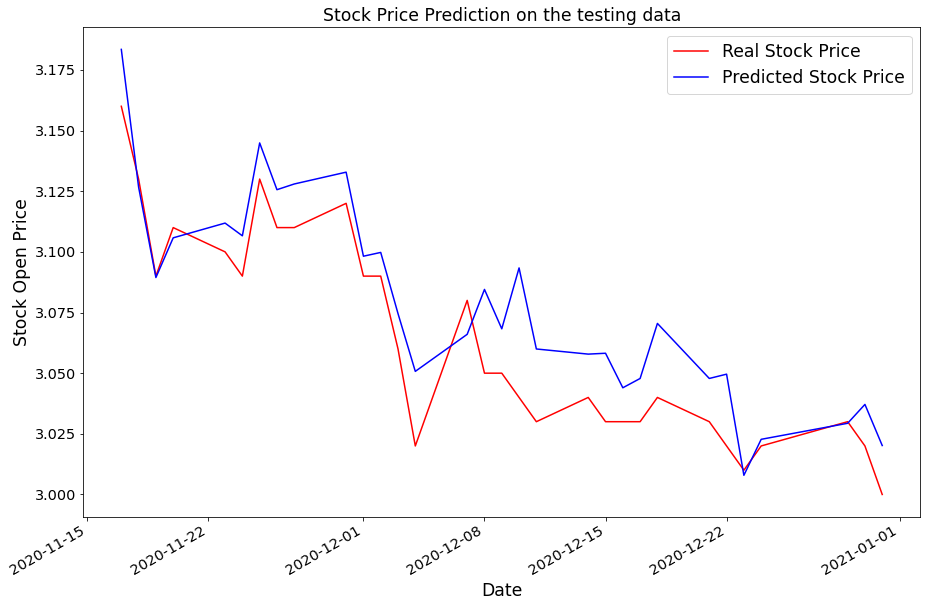

In [ ]:
###Graphical plots on the testing data to see its generalization power
###Even if multiple days are predicted the last day will be plotted
print(y_test.shape)
print(predicted_stock_price.shape)
print("Analysis on the testing set")
print("The mean squared error value for the prediction:" + str(mean_squared_error(y_test, predicted_stock_price)))
'''plt.figure(figsize=[20,15])
plt.grid(True)
plt.plot(y_test[:,-1], color = 'red', label = 'Real Stock Price')
plt.plot(predicted_stock_price[:,-1], color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction on the testing data')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
#print(y_test)
#print(predicted_stock_price)'''

fig, ax = plt.subplots(figsize=(15,10))
ax.plot(testing_set_copy12['Date'].values,y_test[:,-1], color='red',label='Real Stock Price')
ax.plot(testing_set_copy12['Date'].values,predicted_stock_price[:,-1],color = 'blue',label='Predicted Stock Price')
ax.xaxis_date()# interpret the x-axis values as dates
fig.autofmt_xdate()# make space for and rotate the x-axis tick labels
ax.set_xlabel('Date',fontsize='xx-large')
ax.set_ylabel('Stock Open Price',fontsize='xx-large')
ax.set_title('Stock Price Prediction on the testing data',fontsize='xx-large')
#ax.set_xticks(fontsize='x-large')
#ax.set_yticks(fontsize='x-large')
plt.xticks(fontsize='x-large')
plt.yticks(fontsize='x-large')
ax.legend(fontsize="xx-large")
plt.show()

Analysis on the training set
The mean squared error value for the prediction:0.002063640268048211


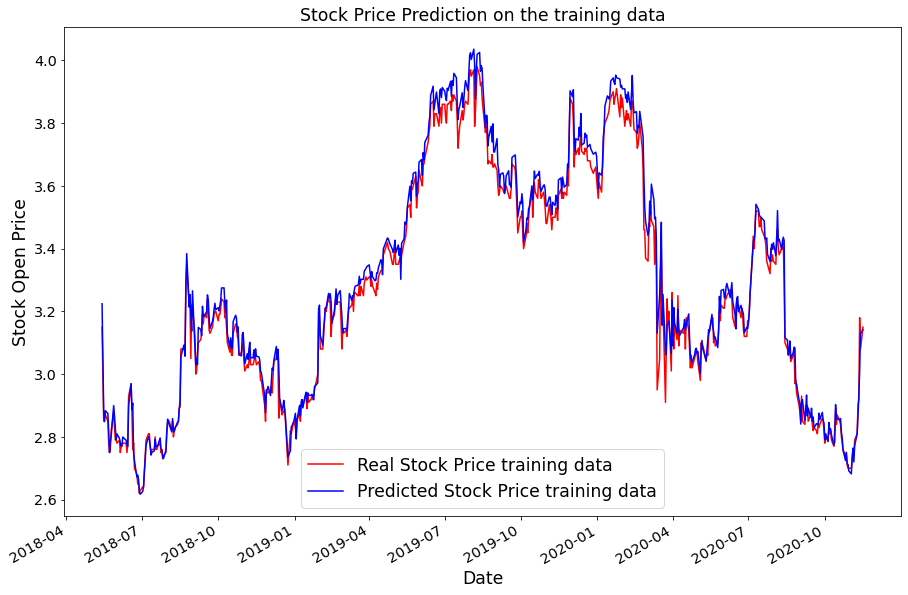

In [ ]:
###Plot a graph and calculate mse scores on the training data to see if the model is overfitted

print("Analysis on the training set")
predicted_stock_price_on_trainingset = regressior.predict(X_train)
##Another scalar is created to get the be able to inverse transform only the Open price
scale = MinMaxScaler()
scale.min_,scale.scale_ = sc.min_[0],sc.scale_[0]##Taking the scalar values from the previous scalar
##Because the previous scalar had n dimensions but now the predicted is only 1 column

##The predicted price and the test data is inverse transformed
predicted_stock_price_on_trainingset1 = scale.inverse_transform(predicted_stock_price_on_trainingset)
y_train1 = scale.inverse_transform(y_train)#.reshape(-1,1))

print("The mean squared error value for the prediction:" + str(mean_squared_error(y_train1, predicted_stock_price_on_trainingset1)))
#print(y_train1[:,-1])
#print(predicted_stock_price_on_trainingset1[:,-1])
'''plt.figure(figsize=[20,15])
plt.grid(True)
plt.plot(y_train1[:,-1], color = 'red', label = 'Real Stock Price training data')
plt.plot(predicted_stock_price_on_trainingset1[:,-1], color = 'blue', label = 'Predicted Stock Price training data')
plt.title('Stock Price Prediction on the training data')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()'''
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(training_set_copy12['Date'].values[90:,],y_train1[:,-1], color='red',label='Real Stock Price training data')
ax.plot(training_set_copy12['Date'].values[90:,],predicted_stock_price_on_trainingset1[:,-1],color = 'blue',label='Predicted Stock Price training data')
ax.xaxis_date()# interpret the x-axis values as dates
fig.autofmt_xdate()# make space for and rotate the x-axis tick labels
ax.set_xlabel('Date',fontsize='xx-large')
ax.set_ylabel('Stock Open Price',fontsize='xx-large')
ax.set_title('Stock Price Prediction on the training data',fontsize='xx-large')
#ax.set_xticks(fontsize='x-large')
#ax.set_yticks(fontsize='x-large')
plt.xticks(fontsize='x-large')
plt.yticks(fontsize='x-large')
ax.legend(fontsize="xx-large")
plt.show()

Plot graphs with the whole duration of 3 years

['Open', 'High', 'Low', 'Close', 'Two_day_sentiment_tweets', 'AverageSentimentNews', 'Date']
     Open   High    Low  ...  AverageSentimentNews       Date  Prediction
756  3.01  3.030  3.005  ...              0.062557 2020-12-23           0
757  3.02  3.035  3.010  ...              0.194700 2020-12-24           0
758  3.03  3.030  3.010  ...             -0.064000 2020-12-29           0
759  3.02  3.030  3.000  ...              0.200000 2020-12-30           0
760  3.00  3.010  2.980  ...             -0.009717 2020-12-31           0

[5 rows x 8 columns]
[[3.1834474]
 [3.1266718]
 [3.089419 ]
 [3.105781 ]
 [3.1118581]
 [3.106616 ]
 [3.1448956]
 [3.12562  ]
 [3.1279747]
 [3.1328473]
 [3.098205 ]
 [3.0997643]
 [3.074552 ]
 [3.0507417]
 [3.0660143]
 [3.0845165]
 [3.0682807]
 [3.0933812]
 [3.0599697]
 [3.0578525]
 [3.05821  ]
 [3.0439818]
 [3.0478144]
 [3.0705047]
 [3.047821 ]
 [3.049592 ]
 [3.0079045]
 [3.0227368]
 [3.0293465]
 [3.0371208]
 [3.02018  ]]
     Open   High    Low  ...  Average

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


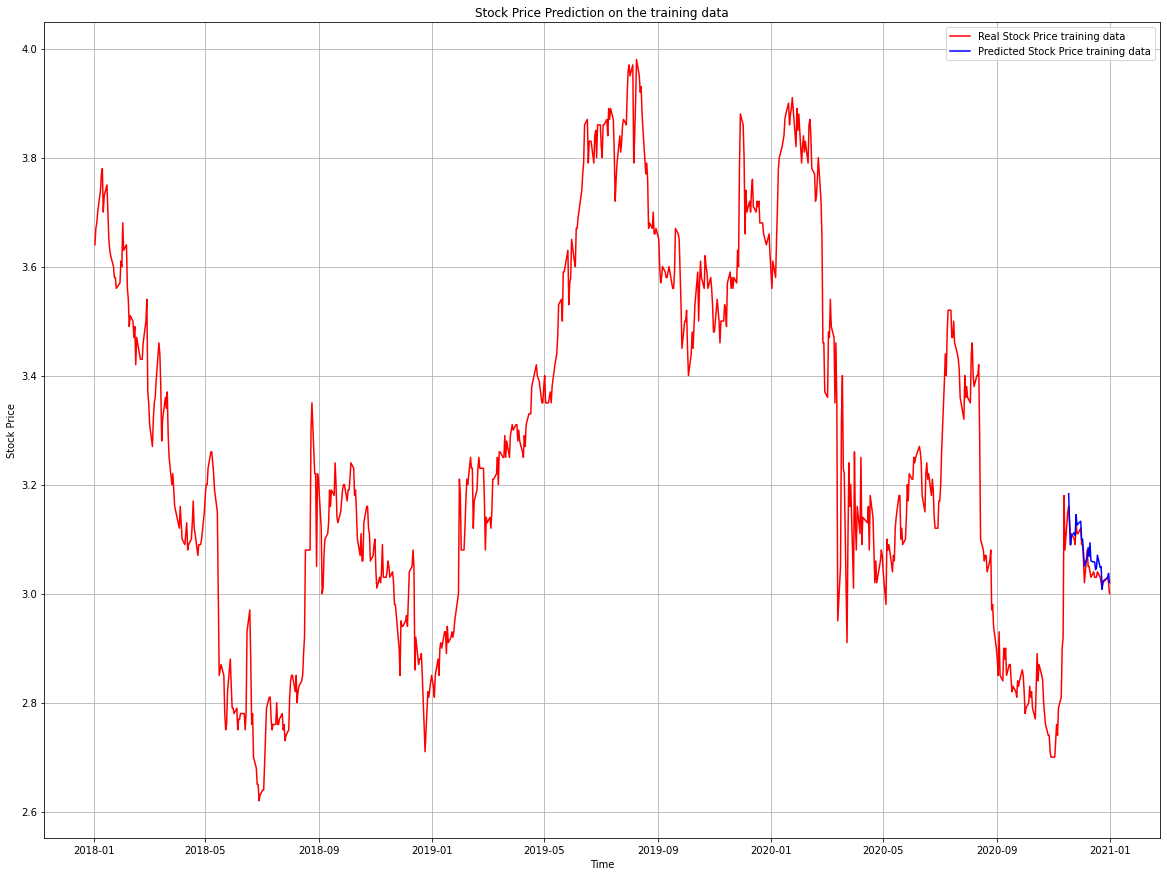

In [ ]:
###Plot graphs with the whole duration, and show the comparison of actual vs prediction
selected_columns_for_analysis = selected_columns
if 'Date' not in selected_columns_for_analysis:
  selected_columns_for_analysis.append('Date')
print(selected_columns_for_analysis)
analysis_data = dataset[selected_columns_for_analysis]
#print(analysis_data)
analysis_data['Prediction'] = 0#analysis_data['Open']#change if to open for proper moving average values
print(analysis_data.tail())
##Append the prediction values to the dataframe
training_set_length = len(analysis_data[analysis_data['Date']<'2020-11-01'])
#print(predicted_stock_price)
for i in range(0,len(predicted_stock_price[:,-1])):
  #print(training_set_length+i)
  analysis_data.loc[training_set_length+i,'Prediction'] = predicted_stock_price[i,0]
  #print(str(predicted_stock_price[i,:])+" "+str(predicted_stock_price[i,0]))
  if i==(len(predicted_stock_price[:,-1])-1):
    #print("Last one")
    for j in range(1,future_days):
      analysis_data.loc[training_set_length+i+j,'Prediction'] = predicted_stock_price[i,j]
print(analysis_data.tail(20))
plt.figure(figsize=[20,15])
plt.grid(True)
plt.plot(analysis_data['Date'], analysis_data['Open'],color = 'red', label = 'Real Stock Price training data')
analysis_plot_data = analysis_data.tail(len(predicted_stock_price[:,-1])+future_days-1)
plt.plot(analysis_plot_data['Date'],analysis_plot_data['Prediction'], color = 'blue', label = 'Predicted Stock Price training data')
plt.title('Stock Price Prediction on the training data')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
analysis_data.to_csv('telstra_predicted.csv',index=False)##Save output to a csv file

Computing the moving average on the prediction data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


     Open   High    Low  Close  ...       Date  Prediction    sma_50   sma_200
751  3.03  3.050  3.020   3.02  ... 2020-12-16    3.043982  1.362212  0.340553
752  3.03  3.050  3.030   3.05  ... 2020-12-17    3.047814  1.423168  0.355792
753  3.04  3.040  3.020   3.03  ... 2020-12-18    3.070505  1.484578  0.371145
754  3.03  3.035  3.010   3.03  ... 2020-12-21    3.047821  1.545535  0.386384
755  3.02  3.030  3.000   3.00  ... 2020-12-22    3.049592  1.606527  0.401632
756  3.01  3.030  3.005   3.01  ... 2020-12-23    3.007905  1.666685  0.416671
757  3.02  3.035  3.010   3.01  ... 2020-12-24    3.022737  1.727139  0.431785
758  3.03  3.030  3.010   3.02  ... 2020-12-29    3.029346  1.787726  0.446932
759  3.02  3.030  3.000   3.00  ... 2020-12-30    3.037121  1.848469  0.462117
760  3.00  3.010  2.980   2.98  ... 2020-12-31    3.020180  1.908872  0.477218

[10 rows x 10 columns]


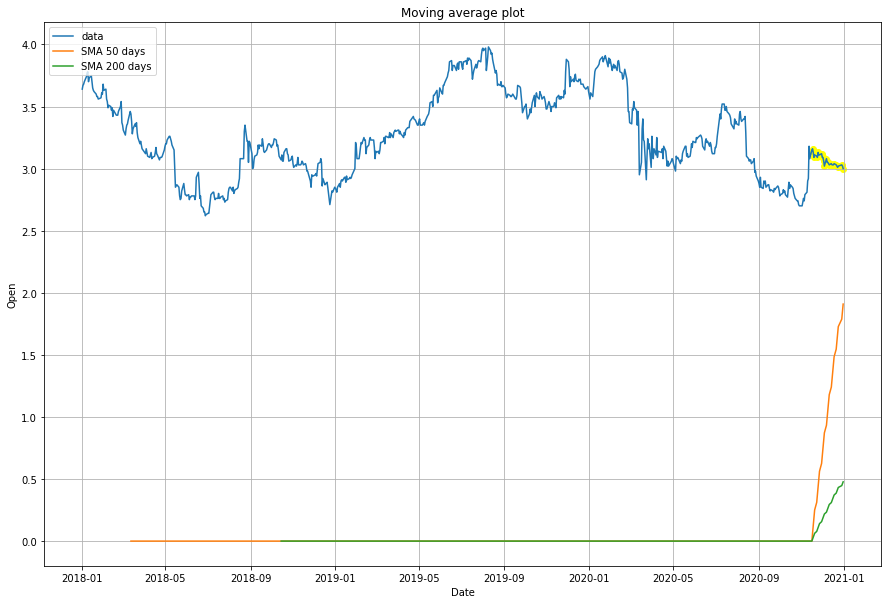

In [ ]:
col = analysis_data.columns.get_loc("Prediction")
analysis_data['sma_50'] = analysis_data.iloc[:,col].rolling(window=50).mean()##Just to check if the above command is implemented properly
analysis_data['sma_200'] = analysis_data.iloc[:,col].rolling(window=200).mean()
print(analysis_data.tail(10))
last_50_days = analysis_data.tail(50)
highlight_dict_golden = {'index':[],'Open':[]}
highlight_dict_death = {'index':[],'Open':[]}
period = {'index':[],'Open':[]}


#print(last_50_days)
date_col = analysis_data.columns.get_loc("Date")
###Highlight the golden and death cross points
for index, each_day in last_50_days.iterrows():
  period['index'].append(each_day['Date'])
  period['Open'].append(each_day['Open'])
  if each_day['sma_50']>each_day['sma_200']:
    highlight_dict_golden['index'].append(each_day['Date'])
    highlight_dict_golden['Open'].append(each_day['Open'])
  if each_day['sma_50']<each_day['sma_200']:
    highlight_dict_death['index'].append(each_day['Date'])
    highlight_dict_death['Open'].append(each_day['Open'])
plt.figure(figsize=[15,10])
plt.grid(True)
plt.plot(analysis_data['Date'],analysis_data['Open'],label='data')
plt.plot(analysis_data['Date'],analysis_data['sma_50'],label='SMA 50 days')
plt.plot(analysis_data['Date'],analysis_data['sma_200'],label='SMA 200 days')
plt.title('Moving average plot')
plt.xlabel('Date')
plt.ylabel('Open')
plt.legend(loc=2)
plt.scatter(highlight_dict_golden['index'],highlight_dict_golden['Open'],color="yellow")
plt.scatter(highlight_dict_death['index'],highlight_dict_death['Open'],color="black")
plt.show()  